In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]
import keras
from keras import layers
from keras import ops
import PIL.Image as Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from patches import Patches, PatchEncoder

 

In [2]:
num_classes = 2
input_shape = (200, 200, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 1  # For real training, use num_epochs=100. 10 is a test value
image_size = 200  # We'll resize input images to this size
patch_size = 20  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

In [3]:
import pathlib                               
# train_dir = pathlib.Path("./dog_cat_dataset/training_set")
train_dir = pathlib.Path("./dog_cat_dataset/testing_set")
test_dir=pathlib.Path("./dog_cat_dataset/testing_set")

print(train_dir)
print(test_dir)


dog_cat_dataset/testing_set
dog_cat_dataset/testing_set


In [4]:
cat_train= list(train_dir.glob('cats/*'))
dog_train= list(train_dir.glob('dogs/*'))

print("Cat length: ", len(cat_train))
print("Dog length: ", len(dog_train))
images_dict = {
    'cats': cat_train,    
    'dogs': dog_train,
}
labels_dict = {
    'cats': 0,
    'dogs': 1,
    
}

Cat length:  101
Dog length:  101


In [5]:
X, y = [], []
for name,images in images_dict.items():#returns key , path for each record
    for image in images:
        if '_DS_Store' in str(image):
            print(f"Skipping _DS_Store file: {image}")
            continue
        if '.DS_Store' in str(image):
            print(f"Skipping .DS_Store file: {image}")
            continue
        img=cv2.imread(str(image))
        if img is not None:
            resize_img = cv2.resize(img, (image_size, image_size))
            X.append(resize_img)
            y.append(labels_dict[name])
        else:
            print(f"Unable to load image: {image}")


In [6]:
X = np.array(X)
y = np.array(y)


In [7]:
from sklearn.model_selection import train_test_split
X_train, Y_train, x_label, y_label = train_test_split(X, y, test_size=0.20 ,random_state=4)

In [8]:
X_train = X_train / 255.0

Y_train = Y_train / 255.0

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [11]:
# # 這是一個名為 Patches 的自定義層（layers.Layer）的程式碼。這個層用於將圖像切割為小塊（patches）。
# @keras.saving.register_keras_serializable()
# class Patches(layers.Layer):
#     def __init__(self, patch_size, **kwargs):
#         super().__init__(**kwargs)
#         self.patch_size = patch_size

#     def call(self, images):
#         input_shape = ops.shape(images)
#         batch_size = input_shape[0]
#         height = input_shape[1]
#         width = input_shape[2]
#         channels = input_shape[3]
#         num_patches_h = height // self.patch_size
#         num_patches_w = width // self.patch_size
#         patches = keras.ops.image.extract_patches(images, size=self.patch_size)
#         patches = ops.reshape(
#             patches,
#             (
#                 batch_size,
#                 num_patches_h * num_patches_w,
#                 self.patch_size * self.patch_size * channels,
#             ),
#         )
#         return patches

#     def get_config(self):
#         config = super().get_config()
#         config.update({"patch_size": self.patch_size})
#         return config
    
#     @classmethod
#     def from_config(cls, config):
#         return cls(patch_size=config["patch_size"])

Image size: 200 X 200
Patch size: 20 X 20
Patches per image: 100
Elements per patch: 1200


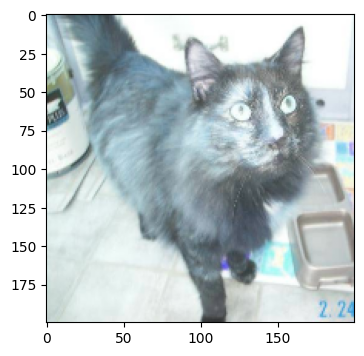

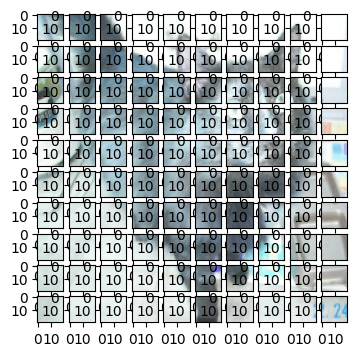

In [12]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image)

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img))
    # plt.axis("off")

In [13]:
# @keras.utils.register_keras_serializable()
# class PatchEncoder(layers.Layer):
#     def __init__(self, num_patches, projection_dim):
#         super().__init__()
#         self.num_patches = num_patches
#         self.projection_dim = projection_dim              
#         self.projection = layers.Dense(units=projection_dim)
#         self.position_embedding = layers.Embedding(
#             input_dim=num_patches, output_dim=projection_dim
#         )

#     def call(self, patch):
#         positions = ops.expand_dims(
#             ops.arange(start=0, stop=self.num_patches, step=1), axis=0
#         )
#         projected_patches = self.projection(patch)
#         encoded = projected_patches + self.position_embedding(positions)
#         return encoded

#     def get_config(self):
#         config = super().get_config()
#         config.update({"num_patches": self.num_patches, "projection_dim": self.projection_dim})
#         return config
    
#     @classmethod
#     def from_config(cls, config):
#         return cls(num_patches=config["num_patches"], projection_dim=config["projection_dim"])

In [14]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    # 使用 PatchEncoder 对这些切割后的小块进行编码
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.5347 - loss: 1.4926 - top-5-accuracy: 1.0000 - val_accuracy: 0.3529 - val_loss: 6.5919 - val_top-5-accuracy: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4652 - loss: 5.4953 - top-5-accuracy: 1.0000
Test accuracy: 46.34%
Test top 5 accuracy: 100.0%


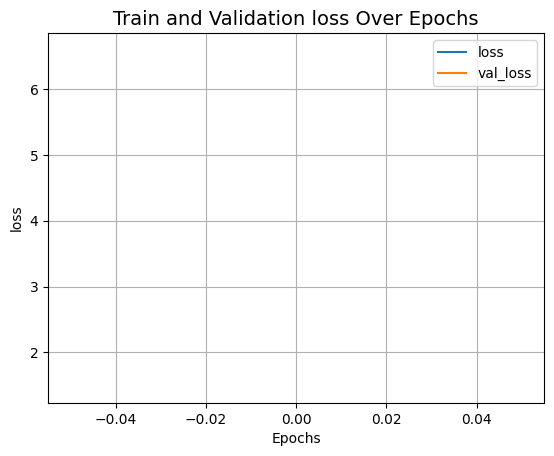

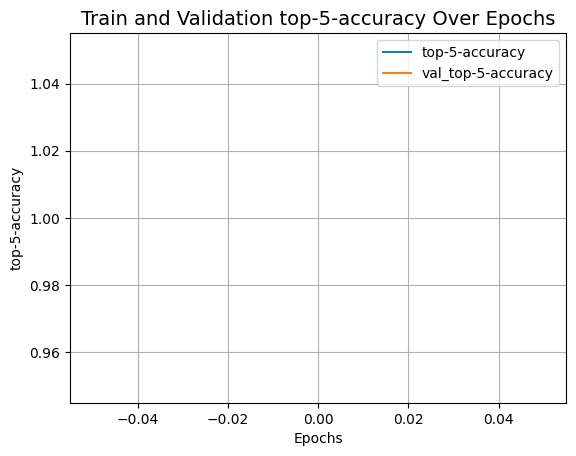

In [15]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=x_label,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(Y_train, y_label)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")

In [16]:
cat_test= list(test_dir.glob('cats/*'))
dog_test= list(test_dir.glob('dogs/*'))
class_names = ['cats', 'dogs']
print("Cat length: ", len(cat_test))
print("Dog length: ", len(dog_test))

Cat length:  101
Dog length:  101


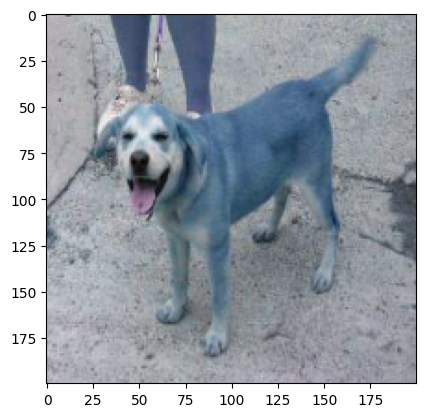

(1, 200, 200, 3)


In [17]:
predict_index = 39
# Grab an image from the test dataset.
image = dog_test[predict_index]
img = cv2.imread(str(image))

resize_img = cv2.resize(img, (image_size, image_size))
resize_img = resize_img / 255.0

plt.figure()
plt.imshow(resize_img)
plt.show()

# Add the image to a batch where it's the only member.
resize_img = (np.expand_dims(resize_img,0))

print(resize_img.shape)


In [18]:
predictions_single = history.model.predict(resize_img)
predictions_label = class_names[np.argmax(predictions_single[0])]

print(predictions_single)
print(predictions_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[  9.107627 -10.174217]]
cats


In [19]:
history.model.save('./models/transformer_model.keras')

In [20]:
importModel = keras.models.load_model('./models/transformer_model.keras')


/Users/jameslam/Desktop/tecky/ai/gpt_env/lib/python3.9/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'patch_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


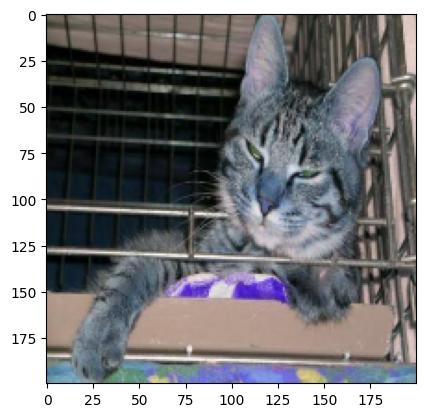

(1, 200, 200, 3)


In [21]:
# Grab an image from the test dataset.
image = cat_test[60]
img = cv2.imread(str(image))

resize_img = cv2.resize(img, (image_size, image_size))
resize_img = resize_img / 255.0

plt.figure()
plt.imshow(resize_img)
plt.show()

# Add the image to a batch where it's the only member.
resize_img = (np.expand_dims(resize_img,0))

print(resize_img.shape)



In [22]:
value = importModel.predict(resize_img)
r = class_names[np.argmax(value[0])]
print(value)
print(r)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
[[ 6.1616936 -5.780183 ]]
cats
